<a href="https://colab.research.google.com/github/Veecks/IA_RNA_HousePricingPredict/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import zipfile
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Carregando os dados

In [118]:
zf = zipfile.ZipFile('/content/drive/MyDrive/IA1s2023/Data/House_Sale/House_Sale.zip')  #aloca o arquivo zip
data = pd.read_csv(zf.open('kc_house_data.csv')) # abre o arquivo CSV 'train.csv' presente dentro do ZIP
data = data.sample(frac=1, random_state=859)
data = data.drop('id', axis=1)
data = data.drop('date', axis=1)
data = data.dropna()
# data = data.fillna(data.mean())
data.head()

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
3645   554663.0         3       2.00         1230      6802     1.5   
7729   340000.0         2       2.00         1250      1178     2.0   
13605  610000.0         3       1.75         1650    221720     1.0   
11222  450000.0         3       1.00         2020      8100     1.0   
17906  239000.0         3       1.00         1510     15022     1.0   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
3645            0     0          3      7      1230.0              0   
7729            0     0          3      7       980.0            270   
13605           0     0          3      7      1650.0              0   
11222           0     0          3      7      1170.0            850   
17906           0     0          3      7      1510.0              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
3645       1940             0    98105  47.6712 -122.279           1850   
7729       1996             0    98136  47.5426 -122.387           1270   
13605      1992             0    98024  47.5297 -121.901           2520   
11222      1956             0    98125  47.7136 -122.288           1480   
17906      1962             0    98003  47.3304 -122.304           1510   

       sqft_lot15  
3645         6398  
7729         1242  
13605      221284  
11222        7620  
17906       12970

# Convertendo os dados para tensores do PyTorch

In [119]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x = data.drop(['price', 'lat', 'long', 'zipcode'], axis=1).values
y = data['price'].values.reshape(-1, 1)

x = torch.tensor(x, dtype=torch.float32).to(device)
y = torch.tensor(y, dtype=torch.float32).to(device)
scaler_mean = x.mean(), y.mean()
x, y = x / scaler_mean[0], y / scaler_mean[1]

In [120]:
kf = KFold(n_splits=5, shuffle=False)
scores = np.zeros(5)

In [121]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 72)
        self.fc2 = nn.Linear(72, 36)
        self.fc3 = nn.Linear(36, 18)
        self.fc4 = nn.Linear(18, 4)
        self.fc5 = nn.Linear(4, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x
    
    def get_params(self):
        return self.parameters()

criterion = nn.L1Loss()
best_models = []

Iterar pelos folds e treinar uma nova rede MLP em cada fold (1b)

In [122]:
def plot1e(model, x_test, y_test, fold_number):
  y_pred = model(x_test)
  fig = plt.figure(figsize=(16,8))
  plt.plot(y.squeeze().clone().to('cpu').numpy()[:70], label='f(x)' )
  plt.plot(y_pred.clone().detach().squeeze().to('cpu').numpy()[:70], label='h(x)' )
  plt.legend()
  plt.title(f'Comportamento h(x) - f(x) para fold {fold_number}')
  plt.show()

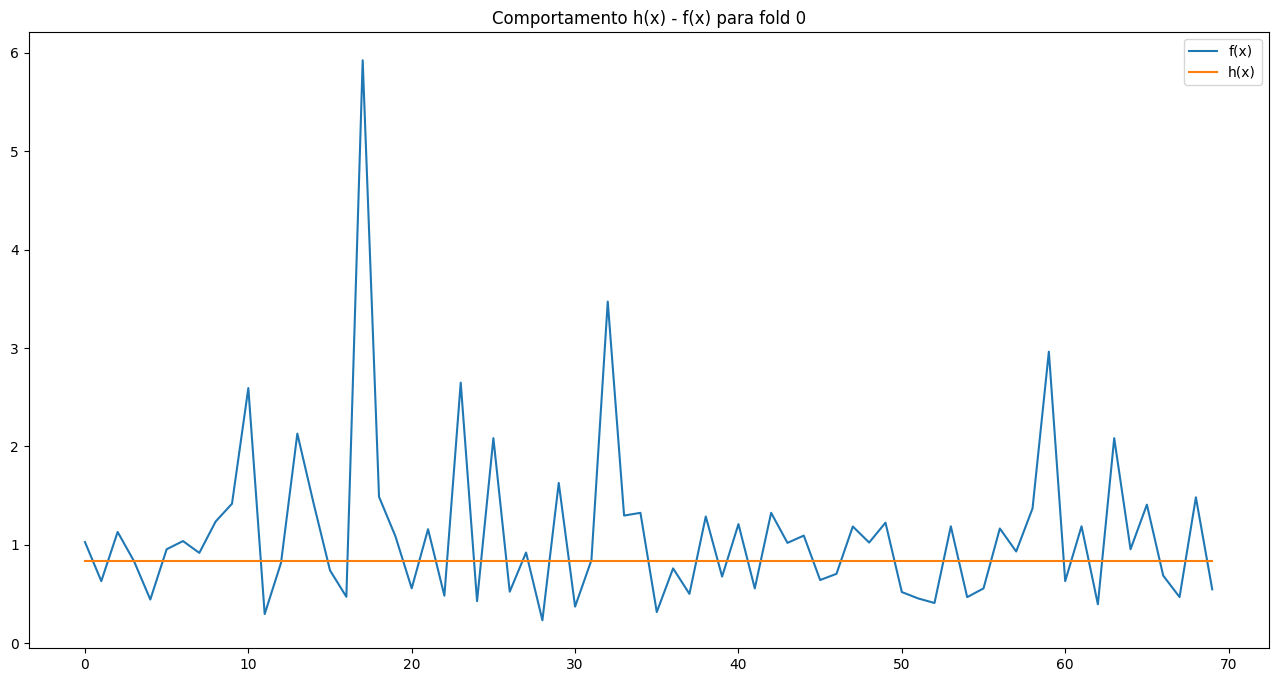

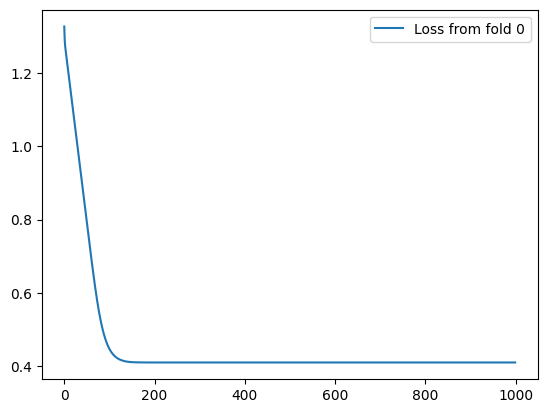

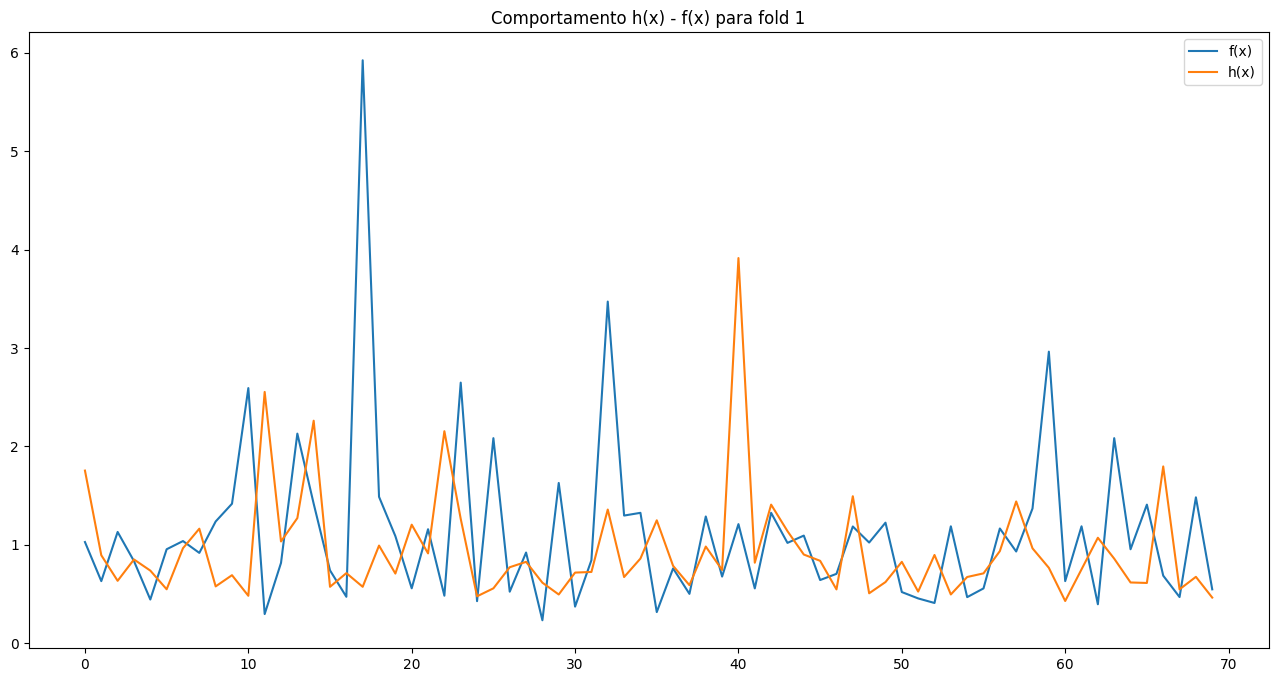

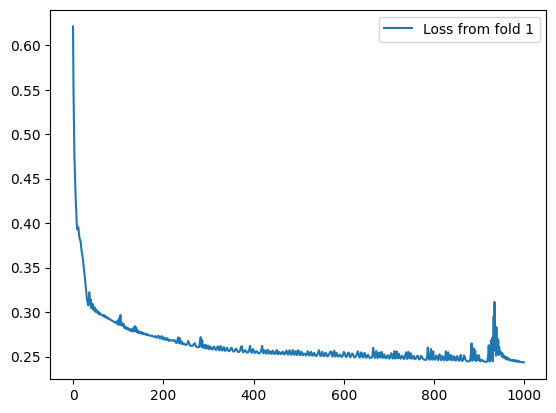

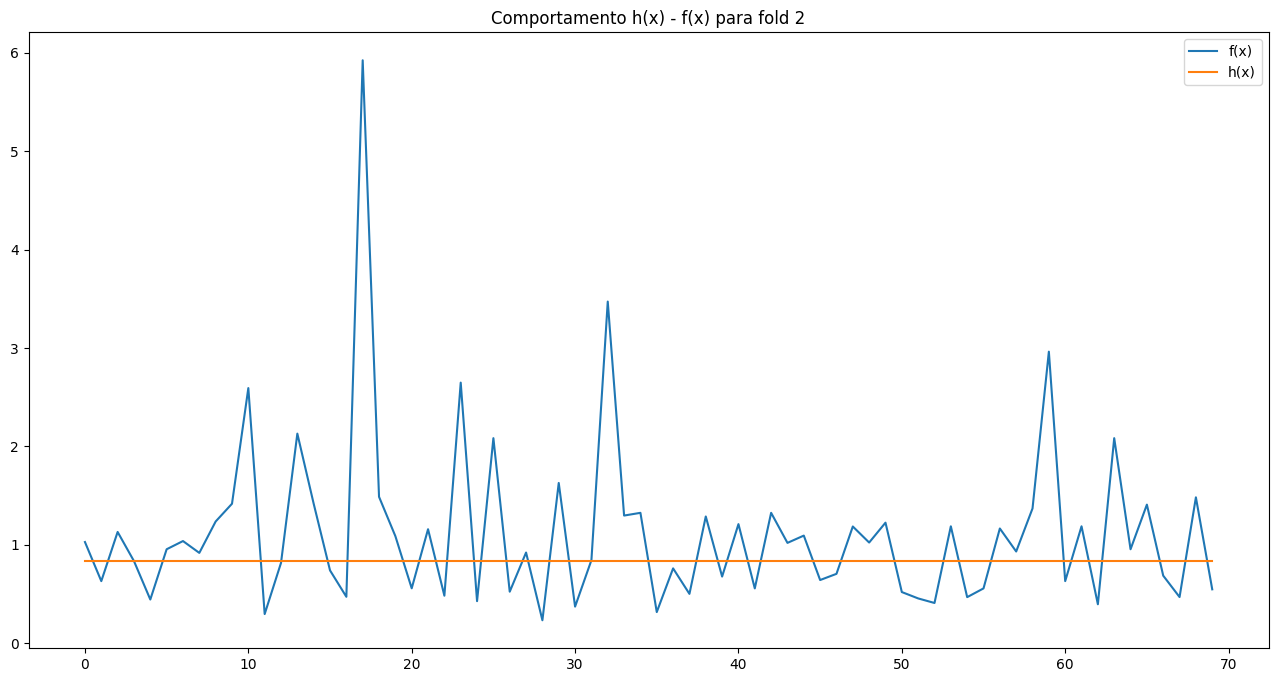

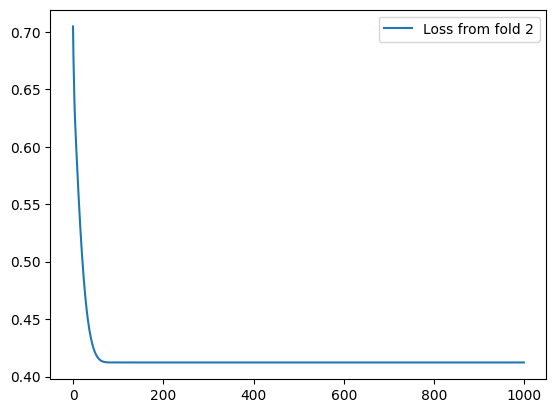

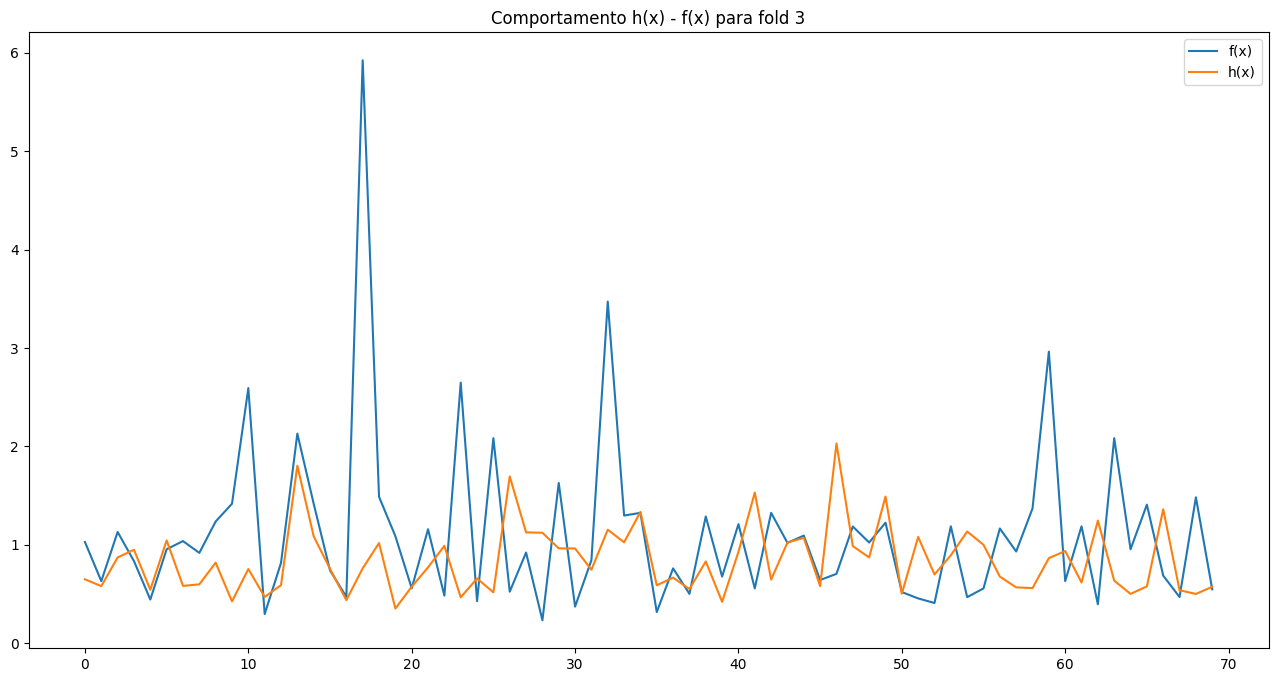

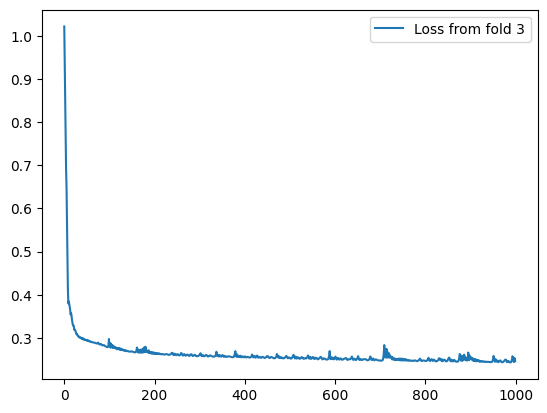

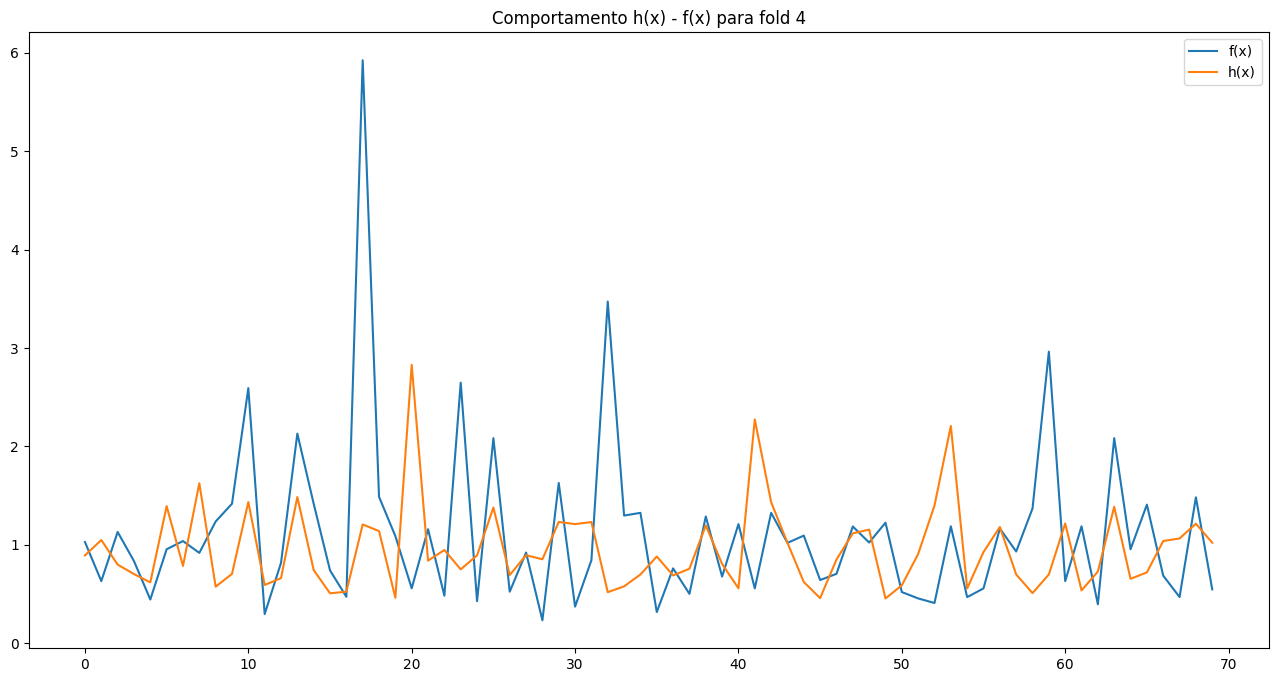

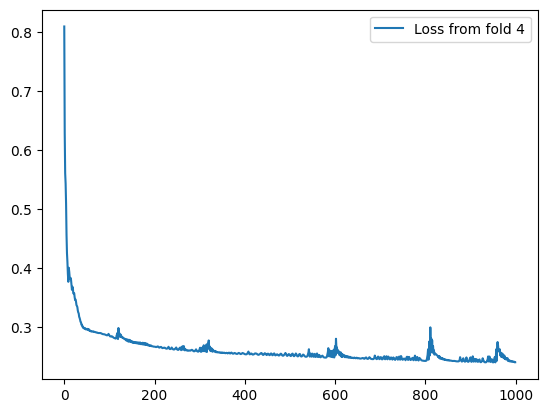

In [123]:
for fold, (train_index, val_index) in enumerate(kf.split(x)):
    X_train, y_train = x[train_index], y[train_index]
    X_val, y_val = x[val_index], y[val_index]
    best_mape = np.inf
    losses = []
    
    # for hidden_size in range(5, 16, 2):
    model = MLP(X_train.shape[1], 1).to(device)
    best_models.append(model)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    epochs = 1000
    
    print()
    for epoch in range(epochs):
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        with torch.no_grad():
            y_val_pred = model(X_val)
            mape = torch.abs((y_val_pred - y_val) / y_val).mean().item()

        if mape < best_mape:
            best_mape = mape
            best_models[fold] = model
            
    with torch.no_grad():
        y_test_pred = best_models[fold](x[val_index]).squeeze()
        y_test_true = y[val_index].squeeze()
        scores[fold] = torch.abs((y_test_pred - y_test_true) / y_test_true).mean()
        plot1e(best_models[fold], X_val, y_val, fold)
    # plt.plot(y_val, label='f(x)')
    # plt.plot(y_pred, label='h(x)')
    plt.plot(range(epochs), losses, label=f'Loss from fold {fold}')
    plt.legend()
    plt.show()

Imprimir os scores obtidos em cada fold

In [124]:
for i in range(len(scores)):
  print(scores[i])

0.4353719651699066
0.26573067903518677
0.4123419523239136
0.2766745984554291
0.2702566683292389


(c) Salvar todos os melhores modelos, pois o professor irá utilizá-los para criar o ranking dos grupos. Adotar a nomenclatura "NOME_GRUPO_RNA_FOLD_X.pth", onde X={1,2,3,4,5};

In [87]:
for i in range(len(best_models)):
  torch.save(best_models[i].state_dict(), f'/content/drive/MyDrive/IA/models/house_pricing/GUILHERME_FRANCINE_RNA_FOLD_{i+1}.pth')

Melhor modelo entre os cinco:

In [135]:
best_score = np.inf
best_model = None
for i in range(len(scores)):
  if scores[i] < best_score:
    best_model = best_models[i]

Calculando a diferença entre as saidas previstas (1d)

---



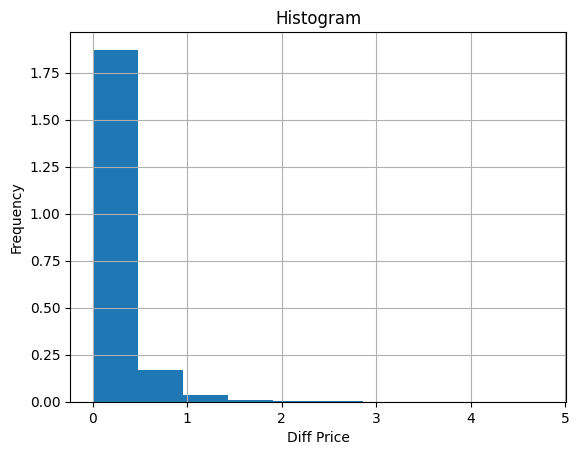

In [136]:
diff = torch.abs(y - best_model(x)).detach().to('cpu').squeeze().numpy()

n, bins, patches = plt.hist(diff, density=True)
plt.xlabel('Diff Price')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.grid(True)
plt.show()

Plotar o gráfico de linhas para todas as amostras, mostrando o comportamento de h(x) e f(x) (1e)

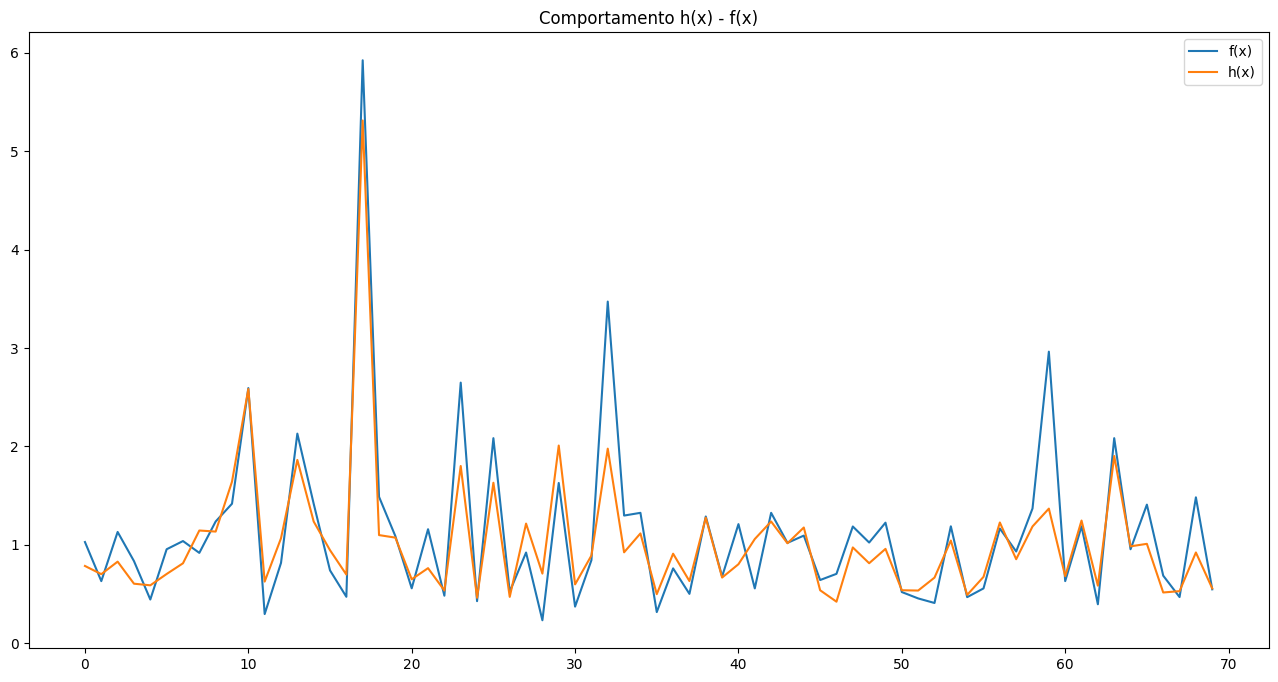

In [138]:
y_pred = best_model(x)
fig = plt.figure(figsize=(16,8))
plt.plot(y.squeeze().clone().to('cpu').numpy()[:70], label='f(x)' )
plt.plot(y_pred.clone().detach().squeeze().to('cpu').numpy()[:70], label='h(x)' )
plt.legend()
plt.title('Comportamento h(x) - f(x)')
plt.show()

Adicionando colun a NEW PRICE (1f)

In [139]:
# adiciona uma nova coluna com os valores estimados pela melhor h(x)
with torch.no_grad():
    y_pred = (best_model(x)*scaler_mean[1]).to('cpu').numpy()
new_data = data.copy()
new_data['NEW PRICE'] = y_pred

Plotar as casas utilizando a funcionalidade HEATMAP considerando a vetor diff calculado no exercĩcio (1). (3a)

In [162]:
import pandas as pd
import folium
from folium.plugins import HeatMap

# carrega os dados das casas em um DataFrame
df = new_data

# cria uma lista de tuplas contendo as coordenadas geográficas e a diferença entre o preço real e o preço estimado
heatmap_data = [(row['lat'], row['long'], row['price'] - row['NEW PRICE']) for _, row in df.iterrows()]

# cria um mapa centrado nas coordenadas médias dos pontos
m = folium.Map(location=[df['lat'].mean(), df['long'].mean()], zoom_start=10)

# cria o heatmap a partir dos dados e adiciona ao mapa
HeatMap(heatmap_data).add_to(m)

# exibe o mapa
m

In [140]:
new_data

price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
3645   554663.0         3       2.00         1230      6802     1.5   
7729   340000.0         2       2.00         1250      1178     2.0   
13605  610000.0         3       1.75         1650    221720     1.0   
11222  450000.0         3       1.00         2020      8100     1.0   
17906  239000.0         3       1.00         1510     15022     1.0   
...         ...       ...        ...          ...       ...     ...   
4390   527550.0         1       0.75          820     59677     1.0   
13145  417400.0         3       3.00         2680     12285     1.0   
14344  234000.0         4       2.00         1630      9010     1.0   
10883  255000.0         3       1.00         1710     12000     1.0   
13842  670000.0         3       2.00         2570     10078     1.5   

       waterfront  view  condition  grade  sqft_above  sqft_basement  \
3645            0     0          3      7      1230.0              0   
7729            0     0          3      7       980.0            270   
13605           0     0          3      7      1650.0              0   
11222           0     0          3      7      1170.0            850   
17906           0     0          3      7      1510.0              0   
...           ...   ...        ...    ...         ...            ...   
4390            0     0          3      5       820.0              0   
13145           0     0          4      8      2680.0              0   
14344           0     0          4      7      1050.0            580   
10883           0     0          4      7      1710.0              0   
13842           0     0          3      8      2570.0              0   

       yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
3645       1940             0    98105  47.6712 -122.279           1850   
7729       1996             0    98136  47.5426 -122.387           1270   
13605      1992             0    98024  47.5297 -121.901           2520   
11222      1956             0    98125  47.7136 -122.288           1480   
17906      1962             0    98003  47.3304 -122.304           1510   
...         ...           ...      ...      ...      ...            ...   
4390       1999             0    98065  47.5316 -121.764           1590   
13145      1970             0    98055  47.4633 -122.196           2610   
14344      1975             0    98092  47.3170 -122.196           1670   
10883      1972             0    98001  47.2616 -122.281           1310   
13842      1965             0    98008  47.6275 -122.120           2660   

       sqft_lot15      NEW PRICE  
3645         6398  423278.468750  
7729         1242  378262.937500  
13605      221284  446966.562500  
11222        7620  325848.625000  
17906       12970  317002.718750  
...           ...            ...  
4390        14163  261420.109375  
13145        9558  627608.875000  
14344        7820  315602.125000  
10883        9600  302066.031250  
13842        8013  568701.500000  

[21611 rows x 20 columns]

Mostra todos os atributos da propriedade (2c)

In [163]:
import folium
import jinja2

# seleciona 1000 propriedades aleatórias
n = 100
df_sample = new_data.sample(n)

# cria o mapa
m = folium.Map(location=[data['lat'].mean(), data['long'].mean()], zoom_start=10)

# itera sobre as colunas do DataFrame
for col in df_sample.columns:
    # adiciona um marcador para cada propriedade
    for i, row in df_sample.iterrows():
        # cria um pop-up com todas as informações do imóvel
        popup_html = jinja2.Template("""
            <b>Informações do imóvel:</b><br>
            {% for column, value in row.items() %}
                {{ column }}: {{ value }}<br>
            {% endfor %}
        """).render(row=row)
        
        # personaliza o pop-up
        popup = folium.Popup(popup_html, max_width=400)
        
        # adiciona o marcador com o pop-up personalizado
        folium.Marker(location=[row['lat'], row['long']], popup=popup, 
                      icon=folium.Icon(color='red', icon='home')).add_to(m)

# exibe o mapa
m

In [167]:
# Botão para o repositório no GitHub
import webbrowser
from IPython.display import HTML

urlF = 'https://github.com/francinefranco/IAproject'
urlG = 'https://github.com/francinefranco/IAproject'
button_text1 = 'Ver repositório no GitHub de Francine'
button_text2 = 'Ver repositório no GitHub de Guilherme'

button1 = '<button onclick="window.location.href=\'{}\'">{}</button>'.format(urlF, button_text1)
button2 = '<button onclick="window.location.href=\'{}\'">{}</button>'.format(urlG, button_text2)
html = button1 + '<br/><br/>' + button2
HTML(html)